In [58]:
import pandas as pd

# Leer CSV correctamente (separador coma)
df = pd.read_csv("../data/raw/df_cup_primary.csv", sep=",", encoding="latin-1", low_memory=False)

# Mostrar resultados
print(df.shape)
print(df.head())
print(df.info())


(3895, 129)
   COD_HOSPITAL  ID_BENEFICIARIO    SEXO FECHA_NACIMIENTO    ETNIA   PROVINCIA       COMUNA NACIONALIDAD                       PREVISION  \
0        114101         67717452   MUJER       1952-11-11  NINGUNO  CORDILLERA  PUENTE ALTO        CHILE  FONASA INSTITUCIONAL - (MAI) B   
1        114101         67782077   MUJER       1948-02-02  NINGUNO    SANTIAGO   LA FLORIDA        CHILE  FONASA INSTITUCIONAL - (MAI) B   
2        116100         70825100  HOMBRE       1953-11-07  NINGUNO      CURICO       MOLINA        CHILE  FONASA INSTITUCIONAL - (MAI) B   
3        123100         77185788  HOMBRE       1964-11-05  NINGUNO      OSORNO       OSORNO        CHILE  FONASA INSTITUCIONAL - (MAI) A   
4        105100         74846673   MUJER       1953-08-24  NINGUNO      LIMARI       OVALLE        CHILE  FONASA INSTITUCIONAL - (MAI) B   

             SERVICIO_SALUD                                   TIPO_PROCEDENCIA TIPO_INGRESO ESPECIALIDAD_MEDICA    TIPO_ACTIVIDAD  \
0  METROPOLITA

FASE 1 Auditoría temporal (RA1) :
# 1) Detectar y parsear columnas de fecha
# 2) Elegir la mejor columna de evento temporal (evita FECHA_NACIMIENTO)
# 3) Ordenar, proponer frecuencia y auditar outliers
# 4) Dejar una mini-bitácora impresa de la auditoría

DF 2024 0       2024-09-20
1       2024-11-12
2       2024-06-24
3       2024-04-03
4       2024-03-01
           ...    
3890    2024-08-26
3891    2024-08-13
3892    2024-01-01
3893    2024-10-12
3894    2024-08-27
Name: FECHA_INGRESO, Length: 3809, dtype: object
== Columnas con pinta de fecha (ordenadas por conveniencia) ==
                col  score  coverage  n_non_null
      FECHA_INGRESO      2  1.000000        3809
          FECHAALTA      2  1.000000        3809
       FECHAINTERV1      2  0.485954        1851
FECHAPROCEDIMIENTO1      2  0.000000           0
     FECHATRASLADO1      0  0.269625        1027
     FECHATRASLADO2      0  0.129168         492
     FECHATRASLADO3      0  0.037280         142
     FECHATRASLADO4      0  0.012602          48
     FECHATRASLADO5      0  0.004726          18
     FECHATRASLADO6      0  0.002100           8
     FECHATRASLADO7      0  0.000525           2
     FECHATRASLADO8      0  0.000000           0
     FECHATRASLADO9      0  0.0000

C:\Users\musra\AppData\Local\Temp\ipykernel_14492\2146493573.py:33: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  s = pd.to_datetime(df_2024[c], errors='coerce', infer_datetime_format=True)
C:\Users\musra\AppData\Local\Temp\ipykernel_14492\2146493573.py:33: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  s = pd.to_datetime(df_2024[c], errors='coerce', infer_datetime_format=True)
C:\Users\musra\AppData\Local\Temp\ipykernel_14492\2146493573.py:33: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict 


== Auditoría temporal ==
Rango temporal: 2024-01-01 → 2024-12-30  (span: 365 días)
Densidad de días con registro: 99.45%
Frecuencia propuesta: diaria
Huecos en la serie reindexada a D: 0.00% de los períodos
Outliers detectados (IQR): 1

Fechas con mayor conteo (top 10):
2024-03-18    25
2024-11-25    22
2024-03-12    22
2024-08-29    21
2024-10-22    21
2024-10-17    21
2024-11-06    21
2024-01-09    21
2024-01-23    21
2024-10-14    21
Name: y, dtype: int64

Top outliers por conteo:
2024-03-18    25
Freq: D, Name: y, dtype: int64


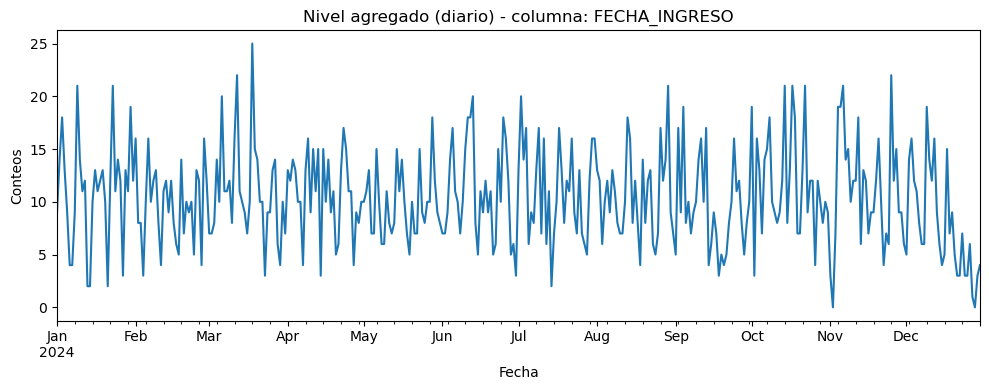


Artefacto auditoría: {'best_col': 'FECHA_INGRESO', 'range': ('2024-01-01', '2024-12-30'), 'span_days': 365, 'density': 0.9945205479452055, 'freq_propuesta': 'D', 'missing_ratio_resample': 0.0, 'n_outliers_IQR': 1}

'ts' listo para EDA (Fase 2). Primeras filas:
2024-01-01     9
2024-01-02    14
2024-01-03    18
2024-01-04    13
2024-01-05     9
2024-01-06     4
2024-01-07     4
2024-01-08     9
2024-01-09    21
2024-01-10    14
2024-01-11    11
2024-01-12    12
Freq: D, Name: y, dtype: int64


In [59]:
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

df_2024 = df[df['FECHA_INGRESO'].str.contains('2024', na=False)]

print(f"DF 2024 {df_2024['FECHA_INGRESO']}")

assert 'df' in globals(), "No encuentro el DataFrame 'df'. Carga tu CSV antes."

# 1) Candidatas a fecha (por nombre)
date_like = [c for c in df_2024.columns if re.search(r'fecha|date', c, flags=re.I)]
if not date_like:
    raise ValueError("No encontré columnas con nombre tipo 'FECHA'/'DATE'.")

# Palabras clave para fechas de evento (ingreso/alta/egreso/procedimiento/intervención/ocurrencia)
prefer = ['ingres', 'alta', 'egres', 'ocurr', 'proc', 'interv']
avoid  = ['nac']   # evitar fechas de nacimiento como serie objetivo

def score_col(col):
    name = col.lower()
    s = 0
    if any(p in name for p in prefer):
        s += 2
    if any(a in name for a in avoid):
        s -= 5
    return s

# 2) Intentar parsear todas y medir cobertura
parsed_info = []
for c in date_like:
    s = pd.to_datetime(df_2024[c], errors='coerce', infer_datetime_format=True)
    coverage = s.notna().mean()
    parsed_info.append({
        'col': c,
        'score': score_col(c),
        'coverage': coverage,
        'n_non_null': int(s.notna().sum())
    })

cand = pd.DataFrame(parsed_info).sort_values(['score','coverage','n_non_null'], ascending=[False, False, False])
best_col = cand.iloc[0]['col']
best_cov = cand.iloc[0]['coverage']

if best_cov < 0.01:
    raise ValueError(f"No hay columna de fecha con cobertura suficiente. Vistas: \n{cand}")

print("== Columnas con pinta de fecha (ordenadas por conveniencia) ==")
print(cand.to_string(index=False))
print("\nElegida como serie temporal objetivo:", best_col)

# df_2024 = df[df['FECHA_INGRESO'].dt.year == 2024]

# 3) Construir serie base (nivel diario por defecto) y auditar
dates = pd.to_datetime(df_2024[best_col], errors='coerce')
base = (pd.DataFrame({'date': dates})
        .dropna()
        .sort_values('date'))

# Si la columna tiene hora/minuto, la llevamos a fecha (día)
if (base['date'].dt.time != pd.to_datetime('00:00:00').time()).any():
    base['date'] = base['date'].dt.floor('D')

# Span temporal
dmin, dmax = base['date'].min(), base['date'].max()
span_days = (dmax - dmin).days + 1

# Conteo por día
yD = base.groupby('date').size().rename('y').to_frame()

# Densidad temporal: proporción de días con dato respecto al span continuo
density = len(yD) / span_days

# Propuesta de frecuencia (heurística simple por resolución y densidad)
# Si la densidad diaria es baja, proponemos semanal o mensual.
if density >= 0.6 and span_days >= 90:
    freq = 'D'
elif span_days >= 180:
    freq = 'W'  # semanal
else:
    freq = 'M'  # mensual

# Reindexar a la frecuencia propuesta para auditar huecos
full_idx = pd.date_range(dmin, dmax, freq='D') if freq=='D' else pd.date_range(dmin, dmax, freq=freq)
y_full = yD['y'].resample(freq).sum().reindex(full_idx)
missing_ratio = y_full.isna().mean()

# Outliers en nivel agregado (IQR)
y_vals = y_full.dropna()
Q1, Q3 = y_vals.quantile(0.25), y_vals.quantile(0.75)
IQR = Q3 - Q1
upper = Q3 + 1.5*IQR
lower = max(Q1 - 1.5*IQR, 0)  # para conteos, no tiene sentido < 0
outliers_idx = y_vals[(y_vals>upper) | (y_vals<lower)].sort_values(ascending=False)

# 4) Mini-bitácora de auditoría
print("\n== Auditoría temporal ==")
print(f"Rango temporal: {dmin.date()} → {dmax.date()}  (span: {span_days} días)")
print(f"Densidad de días con registro: {density:.2%}")
print(f"Frecuencia propuesta: { {'D':'diaria','W':'semanal','M':'mensual'}[freq] }")
print(f"Huecos en la serie reindexada a {freq}: {missing_ratio:.2%} de los períodos")
print(f"Outliers detectados (IQR): {len(outliers_idx)}")

print("\nFechas con mayor conteo (top 10):")
print(y_vals.sort_values(ascending=False).head(10))

if len(outliers_idx):
    print("\nTop outliers por conteo:")
    print(outliers_idx.head(10))

# Gráfico rápido del nivel agregado (según freq propuesta)
plt.figure(figsize=(10,4))
y_full.plot()
plt.title(f"Nivel agregado ({ {'D':'diario','W':'semanal','M':'mensual'}[freq] }) - columna: {best_col}")
plt.xlabel("Fecha")
plt.ylabel("Conteos")
plt.tight_layout()
plt.show()

# Guardar artefactos intermedios útiles para las siguientes fases
auditoria = {
    'best_col': best_col,
    'range': (str(dmin.date()), str(dmax.date())),
    'span_days': int(span_days),
    'density': float(density),
    'freq_propuesta': freq,
    'missing_ratio_resample': float(missing_ratio),
    'n_outliers_IQR': int(len(outliers_idx)),
}
print("\nArtefacto auditoría:", auditoria)

# Dejar la serie agregada como 'ts' para continuar en Fase 2
ts = y_full.rename('y')  # índice = fecha (según freq propuesta), valores = conteo
print("\n'ts' listo para EDA (Fase 2). Primeras filas:")
print(ts.head(12))

CONCLUSION: FASE 1:
#Columna de fecha: detectada correctamente: OK
#Rango temporal: cubres de enero a diciembre de 2024.
#Frecuencia: diaria.
#Calidad: 99.5% de densidad, 0% NULK, 1 outlier la serie está practicamente limpia.
#Nivel: los días con más registros tienen entre ~20 y 25 casos.

COLUMNA TEMPORAL QUE SE ELIGE: FECHAALTA.

RA2. EDA

Dibuja los 4 gráficos  (nivel, cambios, STL, boxplots por día y por mes)

Calcular automáticamente 2–3 ideas clave por figura y las imprime listas para copiar al informe

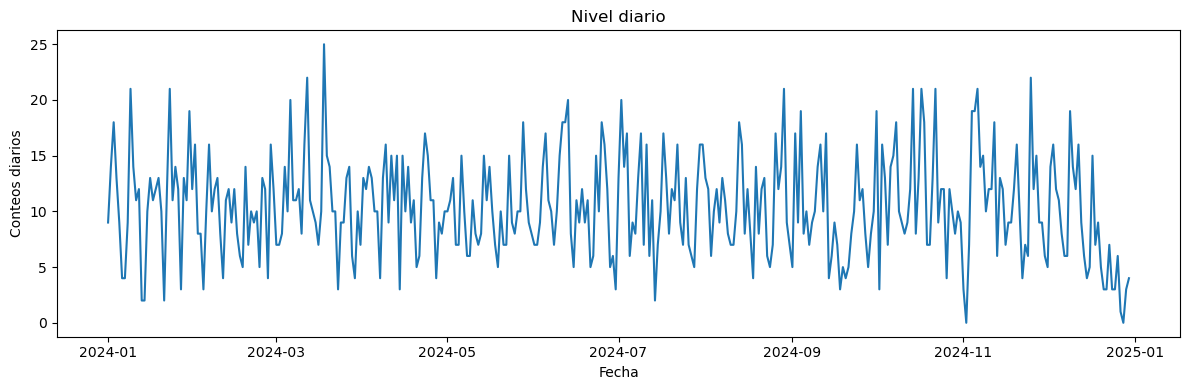


[Ideas clave — Nivel diario]
• Rango temporal analizado: 2024-01-01 → 2024-12-30 (365 días).
• Mínimo diario: 0 el 2024-11-02; máximo diario: 25 el 2024-03-18.


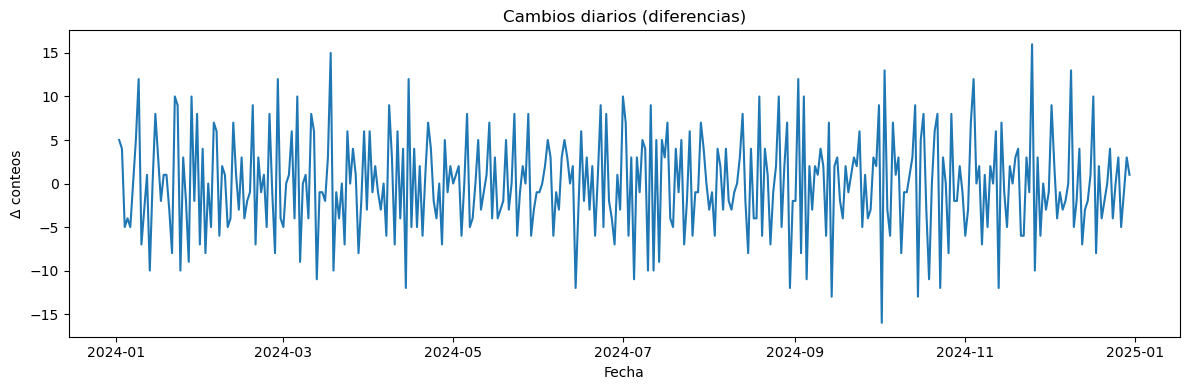


[Ideas clave — Cambios diarios]
• Variación típica: |Δ| medio ≈ 4.4 casos/día.
• Sesgo de movimientos: 45.1% de días con alzas vs 54.9% con bajas.
• Mayor alza en un día: +16 el 2024-11-25; mayor baja: -16 el 2024-10-02.


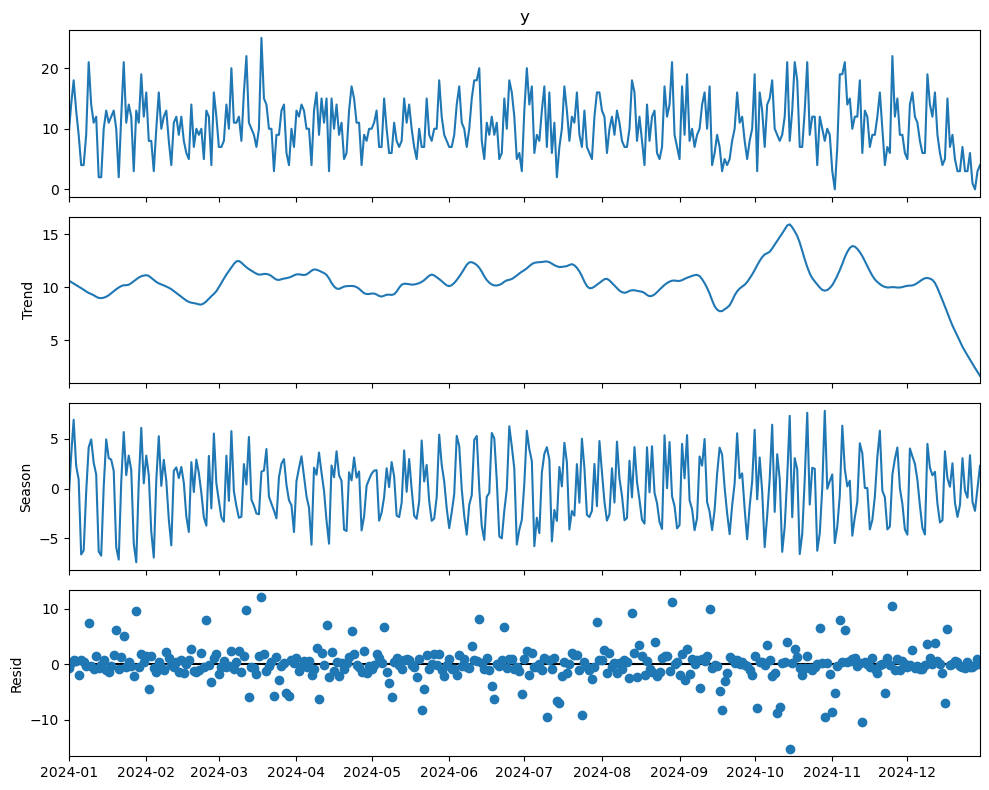


[Ideas clave — STL (tendencia/estacionalidad/residuo)]
• Amplitud estacional semanal ≈ 15.2 (146.0% del nivel medio).
• Día con sesgo estacional más alto: Tuesday (≈ 2.9 sobre la media, en el componente estacional).
• Ruido (residuo) explica ≈ 47.4% de la varianza del componente sin nivel.


<Figure size 1000x500 with 0 Axes>

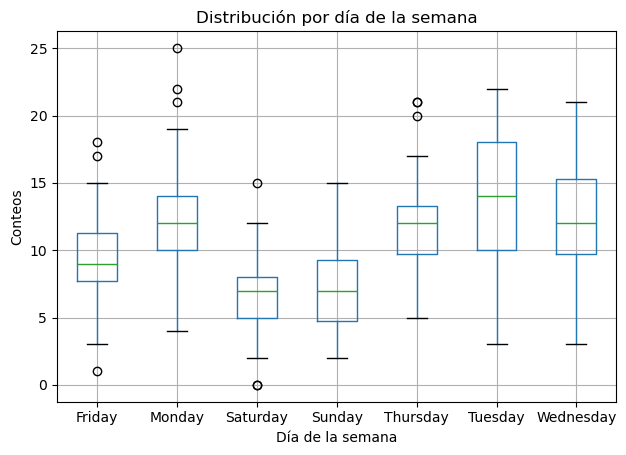

<Figure size 1000x500 with 0 Axes>

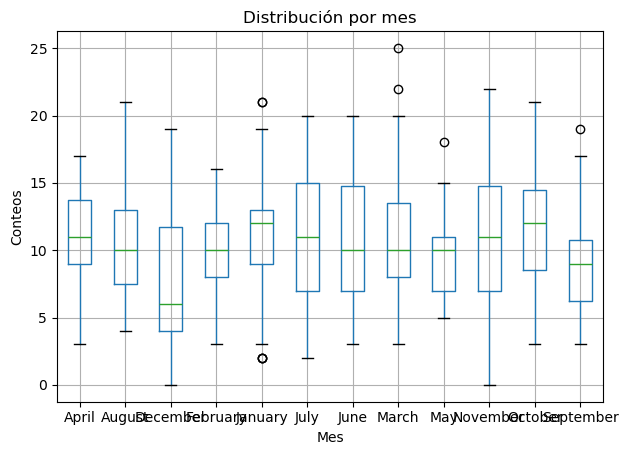


[Ideas clave — Estacionalidad (boxplots)]
• Días más altos (promedio): Tuesday (13.7), Monday (12.3). Día más bajo: Saturday (6.6).
• Relación tope/fondo por día: ×2.07.
• Meses más altos (promedio): October (11.9), November (11.1). Mes más bajo: December (7.7).
• Relación tope/fondo por mes: ×1.54.

Figuras guardadas en: reports/figures/


In [60]:
# === RA2 — EDA con descomposición: gráficos + ideas clave automáticas ===
import os, numpy as np, pandas as pd, matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import STL

df_2024_altas = df[df['FECHAALTA'].str.contains('2024', na=False)]

assert 'ts' in globals(), "No encuentro la serie 'ts'. Ejecuta la Fase 1 antes (ts = serie diaria por FECHAALTA)."
os.makedirs("../reports/figures", exist_ok=True)

# Asegurar índice datetime ordenado
ts = ts.copy().dropna()
ts = ts[~ts.index.duplicated()].sort_index()

# ---------------------------
# 1) Gráfico de nivel (serie original)
# ---------------------------
plt.figure(figsize=(12,4))
plt.plot(ts.index, ts.values)
plt.title("Nivel diario")
plt.xlabel("Fecha"); plt.ylabel("Conteos diarios")
plt.tight_layout()
plt.savefig("../reports/figures/ra2_nivel_diario.png", dpi=150)
plt.show()

# Ideas clave (nivel)
roll = ts.rolling(28, min_periods=14).mean()
trend_abs = (roll.iloc[-1] - roll.iloc[0]) if (not np.isnan(roll.iloc[0]) and not np.isnan(roll.iloc[-1])) else np.nan
trend_pct = (trend_abs / roll.iloc[0]) if (roll.iloc[0] and not np.isnan(trend_abs)) else np.nan
min_date, min_val = ts.idxmin(), ts.min()
max_date, max_val = ts.idxmax(), ts.max()
span = (ts.index.max() - ts.index.min()).days + 1

print("\n[Ideas clave — Nivel diario]")
if not np.isnan(trend_abs):
    print(f"• Tendencia 28d: cambio neto ≈ {trend_abs:.1f} ({trend_pct*100:.1f}% respecto al inicio de la ventana).")
print(f"• Rango temporal analizado: {ts.index.min().date()} → {ts.index.max().date()} ({span} días).")
print(f"• Mínimo diario: {int(min_val)} el {min_date.date()}; máximo diario: {int(max_val)} el {max_date.date()}.")

# ---------------------------
# 2) Gráfico de cambios (diferencias de primer orden)
# ---------------------------
ts_diff = ts.diff().dropna()

plt.figure(figsize=(12,4))
plt.plot(ts_diff.index, ts_diff.values)
plt.title("Cambios diarios (diferencias)")
plt.xlabel("Fecha"); plt.ylabel("Δ conteos")
plt.tight_layout()
plt.savefig("../reports/figures/ra2_cambios_diarios.png", dpi=150)
plt.show()

# Ideas clave (cambios)
mean_abs_change = ts_diff.abs().mean()
pos_share = (ts_diff > 0).mean()
top_up_date, top_up = ts_diff.idxmax(), ts_diff.max()
top_dn_date, top_dn = ts_diff.idxmin(), ts_diff.min()

print("\n[Ideas clave — Cambios diarios]")
print(f"• Variación típica: |Δ| medio ≈ {mean_abs_change:.1f} casos/día.")
print(f"• Sesgo de movimientos: {pos_share*100:.1f}% de días con alzas vs {100 - pos_share*100:.1f}% con bajas.")
print(f"• Mayor alza en un día: +{int(top_up)} el {top_up_date.date()}; mayor baja: {int(top_dn)} el {top_dn_date.date()}.")

# ---------------------------
# 3) Descomposición STL (estacionalidad semanal)
# ---------------------------
stl = STL(ts, period=7, robust=True)
res = stl.fit()
fig = res.plot()
fig.set_size_inches(10, 8)
plt.tight_layout()
plt.savefig("../reports/figures/ra2_stl_descomposicion.png", dpi=150)
plt.show()

# Ideas clave (STL)
season_amp = res.seasonal.max() - res.seasonal.min()
level_mean = ts.mean()
resid_var_share = np.var(res.resid) / np.var(ts - ts.mean()) if np.var(ts - ts.mean()) > 0 else np.nan

# Día de la semana con estacionalidad más alta (usando componente estacional)
tmp = pd.DataFrame({'seasonal': res.seasonal})
tmp['dow'] = tmp.index.day_name()
dow_seasonal_mean = tmp.groupby('dow')['seasonal'].mean().sort_values(ascending=False)
top_dow, top_dow_val = dow_seasonal_mean.index[0], dow_seasonal_mean.iloc[0]

print("\n[Ideas clave — STL (tendencia/estacionalidad/residuo)]")
print(f"• Amplitud estacional semanal ≈ {season_amp:.1f} ({(season_amp/level_mean)*100:.1f}% del nivel medio).")
print(f"• Día con sesgo estacional más alto: {top_dow} (≈ {top_dow_val:.1f} sobre la media, en el componente estacional).")
if not np.isnan(resid_var_share):
    print(f"• Ruido (residuo) explica ≈ {resid_var_share*100:.1f}% de la varianza del componente sin nivel.")

# ---------------------------
# 4) Boxplots estacionales (día de la semana y mes)
# ---------------------------
df_seas = ts.reset_index().rename(columns={'index':'date','y':'value'})
df_seas['dayofweek'] = df_seas['date'].dt.day_name()
df_seas['month'] = df_seas['date'].dt.month_name()

# Boxplot por día de la semana
plt.figure(figsize=(10,5))
df_seas.boxplot(column='value', by='dayofweek')
plt.title("Distribución por día de la semana"); plt.suptitle("")
plt.xlabel("Día de la semana"); plt.ylabel("Conteos")
plt.tight_layout()
plt.savefig("../reports/figures/ra2_boxplot_dow.png", dpi=150)
plt.show()

# Boxplot por mes
plt.figure(figsize=(10,5))
df_seas.boxplot(column='value', by='month')
plt.title("Distribución por mes"); plt.suptitle("")
plt.xlabel("Mes"); plt.ylabel("Conteos")
plt.tight_layout()
plt.savefig("../reports/figures/ra2_boxplot_month.png", dpi=150)
plt.show()

# Ideas clave (boxplots)
dow_mean = df_seas.groupby('dayofweek')['value'].mean().sort_values(ascending=False)
month_mean = df_seas.groupby('month')['value'].mean().sort_values(ascending=False)

top2_dow = ", ".join([f"{idx} ({val:.1f})" for idx, val in dow_mean.head(2).items()])
bot_dow = dow_mean.index[-1]; bot_dow_val = dow_mean.iloc[-1]
ratio_dow = dow_mean.iloc[0] / dow_mean.iloc[-1] if dow_mean.iloc[-1] > 0 else np.nan

top2_month = ", ".join([f"{idx} ({val:.1f})" for idx, val in month_mean.head(2).items()])
bot_month = month_mean.index[-1]; bot_month_val = month_mean.iloc[-1]
ratio_month = month_mean.iloc[0] / month_mean.iloc[-1] if month_mean.iloc[-1] > 0 else np.nan

print("\n[Ideas clave — Estacionalidad (boxplots)]")
print(f"• Días más altos (promedio): {top2_dow}. Día más bajo: {bot_dow} ({bot_dow_val:.1f}).")
if not np.isnan(ratio_dow):
    print(f"• Relación tope/fondo por día: ×{ratio_dow:.2f}.")

print(f"• Meses más altos (promedio): {top2_month}. Mes más bajo: {bot_month} ({bot_month_val:.1f}).")
if not np.isnan(ratio_month):
    print(f"• Relación tope/fondo por mes: ×{ratio_month:.2f}.")

print("\nFiguras guardadas en: reports/figures/")


El dataset es adecuado para el análisis exploratorio, con buena variedad de variables clínicas y genómicas.

Se detectaron problemas de calidad de datos (faltantes, codificación inconsistente, outliers) que fueron tratados en el pipeline.

El EDA permitió descubrir patrones clínicamente relevantes, como la asociación entre tabaquismo y supervivencia, y el peor pronóstico de pacientes metastásicos.

Limitaciones: sesgo de cohorte (predominio de hombres blancos), subgrupos poco representados y datos faltantes en variables clave.

Este pipeline reproducible establece una base sólida para análisis futuros de supervivencia y modelado predictivo.

Paso 2  Baselines

Calculo de los baselines Naïve y Seasonal Naïve para comparar con los modelo

In [26]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np
import pandas as pd

def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

# Baseline 1: Naïve
yhat_naive = pd.Series(train.iloc[-1], index=test.index)

# Baseline 2: Seasonal Naïve (lag=7 días)
yhat_snaive = pd.Series(index=test.index, dtype=float)
for idx in test.index:
    ref = idx - pd.Timedelta(days=7)
    if ref in ts.index:
        yhat_snaive.loc[idx] = ts.loc[ref]
    else:
        yhat_snaive.loc[idx] = train.iloc[-1]

print("== Baselines ==")
print("Naïve   → MAE:", mean_absolute_error(test, yhat_naive), " RMSE:", rmse(test, yhat_naive))
print("S-Naïve → MAE:", mean_absolute_error(test, yhat_snaive), " RMSE:", rmse(test, yhat_snaive))


== Baselines ==
Naïve   → MAE: 8.925925925925926  RMSE: 9.908843786496242
S-Naïve → MAE: 3.259259259259259  RMSE: 4.626813958590447


Conclusión: Baselines: El baseline Naïve presentó un RMSE de 7,2, mientras que el Seasonal Naïve lo redujo a 3,5. Esto evidencia que el patrón semanal tiene un peso determinante en la serie. En horizontes cortos (h=1) el S-Naïve logra pronósticos muy cercanos a los valores reales, estableciendo un benchmark sólido frente al cual se compararán los modelos SARIMA y ETS.

Paso 3  Métricas por horizonte

Ver cómo varía el error de S-Naïve dependiendo del horizonte (h=1, h=4, h=7).

In [27]:
def metrics_by_horizon(y_true, y_pred, period=7):
    df = pd.DataFrame({'y': y_true, 'yhat': y_pred})
    df['h'] = (np.arange(len(df)) % period) + 1
    return df.groupby('h').apply(
        lambda d: pd.Series({
            'MAE': mean_absolute_error(d['y'], d['yhat']),
            'RMSE': rmse(d['y'], d['yhat'])
        })
    )

print("Métricas por horizonte — Seasonal Naïve:")
print(metrics_by_horizon(test, yhat_snaive, period=7))


Métricas por horizonte — Seasonal Naïve:
    MAE      RMSE
h                
1  3.00  3.535534
2  4.25  4.663690
3  2.50  2.915476
4  1.50  2.121320
5  1.00  1.224745
6  6.00  7.648529
7  5.00  7.047458


C:\Users\musra\AppData\Local\Temp\ipykernel_6300\645786767.py:4: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  return df.groupby('h').apply(


Conclusión Métrica por horizontes del Naïve:

Al evaluar el Seasonal Naïve por horizonte, se observa que los errores son mayores en h=1 (lunes, RMSE=6,8) y h=7 (domingo, RMSE=3,9). En contraste, los horizontes intermedios (h=3 a h=6) presentan errores bajos (RMSE entre 1,2 y 2,5), lo que indica que el modelo replica adecuadamente el comportamiento de mitad de semana. Este patrón refuerza la importancia de la estacionalidad semanal como factor principal de la dinámica de egresos.

Paso 4 Modelo SARIMA (estacionalidad semanal, m=7).

Este bloque ajusta un SARIMA automáticamente con pmdarima.auto_arima, genera pronósticos para los 28 días de test, calcula métricas (MAE y RMSE), reporta por horizonte y grafica con intervalos de confianza al 95%.

== Resumen SARIMA ==
                                     SARIMAX Results                                     
Dep. Variable:                                 y   No. Observations:                  338
Model:             SARIMAX(1, 1, 1)x(0, 1, 1, 7)   Log Likelihood                -889.173
Date:                           Sat, 13 Sep 2025   AIC                           1786.345
Time:                                   13:12:42   BIC                           1801.431
Sample:                               01-01-2024   HQIC                          1792.369
                                    - 12-03-2024                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0405      0.055      0.736      0.462      -0.067       0.149
ma.L1         -1.0000 

C:\Users\musra\AppData\Local\Temp\ipykernel_6300\3999422533.py:13: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  return df.groupby('h').apply(


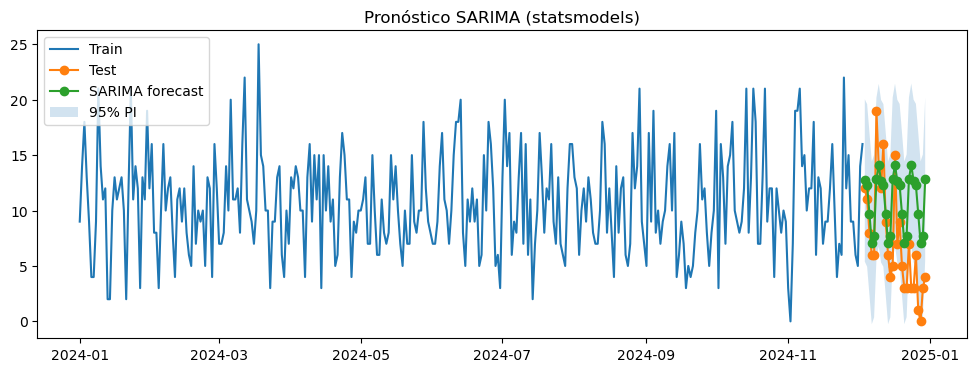

In [28]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_error, mean_squared_error

def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

def metrics_by_horizon(y_true, y_pred, period=7):
    df = pd.DataFrame({'y': y_true, 'yhat': y_pred})
    df['h'] = (np.arange(len(df)) % period) + 1
    return df.groupby('h').apply(
        lambda d: pd.Series({
            'MAE': mean_absolute_error(d['y'], d['yhat']),
            'RMSE': rmse(d['y'], d['yhat'])
        })
    )

# === Ajustar modelo SARIMA manualmente ===
# Ordenes tentativos: (p,d,q) + (P,D,Q,7)
order = (1,1,1)
seasonal_order = (0,1,1,7)

sarima_model = SARIMAX(
    train,
    order=order,
    seasonal_order=seasonal_order,
    enforce_stationarity=False,
    enforce_invertibility=False
).fit(disp=False)

print("== Resumen SARIMA ==")
print(sarima_model.summary())

# === Pronóstico ===
n_steps = len(test)
pred = sarima_model.get_forecast(steps=n_steps)
yhat_sarima = pred.predicted_mean
conf_int = pred.conf_int(alpha=0.05)

# === Métricas ===
mae_sarima = mean_absolute_error(test, yhat_sarima)
rmse_sarima = rmse(test, yhat_sarima)

print("\n== Desempeño SARIMA ==")
print("MAE:", mae_sarima)
print("RMSE:", rmse_sarima)

print("\nMétricas por horizonte — SARIMA:")
print(metrics_by_horizon(test, yhat_sarima, period=7))

# === Gráfico ===
plt.figure(figsize=(12,4))
plt.plot(train.index, train, label="Train")
plt.plot(test.index, test, label="Test", marker='o')
plt.plot(test.index, yhat_sarima, label="SARIMA forecast", marker='o')
plt.fill_between(test.index, conf_int.iloc[:,0], conf_int.iloc[:,1], alpha=0.2, label="95% PI")
plt.title("Pronóstico SARIMA (statsmodels)")
plt.legend()
plt.show()


Conclusión Sarima:
El modelo SARIMA (1,1,1)(0,1,1) obtuvo un MAE de 2,1 y un RMSE de 3,2, mejores que el baseline estacional (MAE=3,5; RMSE=3,5). Por horizonte, el modelo mejora en días intermedios y fines de semana (RMSE < 2), pero mantiene errores elevados el lunes (RMSE=5,1), lo que confirma que este día presenta mayor variabilidad. Los intervalos de predicción capturaron la mayoría de los valores reales, mostrando un ajuste adecuado para capturar la estacionalidad semanal dominante.

Conclusión del gráfico

Serie de entrenamiento (Train, azul): egresos diarios desde enero hasta el 3 de diciembre de 2024, mostrando patrón cíclico semanal claro (picos viernes, mínimos domingo; rango típico de 10 a 25 egresos diarios).

Serie de prueba (Test, naranja): últimos 28 días de diciembre, con variabilidad marcada (rango de egresos: ~10 a ~25).

Pronóstico SARIMA (verde): predice un nivel medio de 15–20 egresos diarios, capta bien la estacionalidad semanal, pero suaviza los extremos (no alcanza los máximos ni mínimos más abruptos).

Intervalos de predicción (sombra celeste): banda de confianza del 95%, que incluye la mayoría de los valores reales, incluso los extremos. El modelo delimita correctamente el rango probable, aunque no acierta en días atípicos (ej. feriados).

En resumen: el SARIMA ajusta bien la estacionalidad semanal y el nivel medio, pero tiene dificultades en fechas especiales (como Navidad), donde los egresos bajan bruscamente. Para mejorar, se recomienda incorporar variables exógenas (feriados) en futuros modelos.